
## SPAM Classification

In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName("spam").master("local[*]").getOrCreate()

# File location and type
file_location = "data/spamham.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .option("quote", '"') \
  .option("escape", '"') \
  .load(file_location)

display(df)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/20 02:51:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/01/20 02:51:26 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


DataFrame[text: string, spam: int]

In [3]:
def elim_subject(x):
  return "".join(x.split(":")[1:]).strip()

#t = "Subject: cigarettes wholesale ! hywwzzlzd  $ 19 . 95 and up ! buy cartons of cigarettes wholesale , starting at $ 19 . 95 .  free shipping !  why pay state taxes ? 100 % legal . mailed from swiss bonded warehouse . #for  personal use only , must be 18 years of age and older , verified by credit  card .  aol users click here  to be removed from future mailings , reply to this email with remove in the subject line ."

#print(elim_subject(t))
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

elim_subject_udf = udf(elim_subject, StringType())

df_processed = df.withColumn('message', elim_subject_udf(df['text']))
df_processed.show(100)



+--------------------+----+--------------------+
|                text|spam|             message|
+--------------------+----+--------------------+
|Subject: naturall...|   1|naturally irresis...|
|Subject: the stoc...|   1|the stock trading...|
|Subject: unbeliev...|   1|unbelievable new ...|
|Subject: 4 color ...|   1|4 color printing ...|
|Subject: do not h...|   1|do not have money...|
|Subject: great nn...|   1|great nnews  hell...|
|Subject: here ' s...|   1|here ' s a hot pl...|
|Subject: save you...|   1|save your money b...|
|Subject: undelive...|   1|undeliverable  ho...|
|Subject: save you...|   1|save your money b...|
|Subject: las vega...|   1|las vegas high ri...|
|Subject: save you...|   1|save your money b...|
|Subject: brighten...|   1|brighten those te...|
|Subject: wall str...|   1|wall street pheno...|
|Subject: fpa noti...|   1|fpa notice  ebay ...|
|Subject: search e...|   1|search engine pos...|
|Subject: only our...|   1|only our software...|
|Subject: localize..

In [4]:
from pyspark.ml.feature import Tokenizer
tokenizer = Tokenizer(inputCol='message', outputCol='words')
wordsData = tokenizer.transform(df_processed)
display(wordsData)
wordsData.show(50)

DataFrame[text: string, spam: int, message: string, words: array<string>]

+--------------------+----+--------------------+--------------------+
|                text|spam|             message|               words|
+--------------------+----+--------------------+--------------------+
|Subject: naturall...|   1|naturally irresis...|[naturally, irres...|
|Subject: the stoc...|   1|the stock trading...|[the, stock, trad...|
|Subject: unbeliev...|   1|unbelievable new ...|[unbelievable, ne...|
|Subject: 4 color ...|   1|4 color printing ...|[4, color, printi...|
|Subject: do not h...|   1|do not have money...|[do, not, have, m...|
|Subject: great nn...|   1|great nnews  hell...|[great, nnews, , ...|
|Subject: here ' s...|   1|here ' s a hot pl...|[here, ', s, a, h...|
|Subject: save you...|   1|save your money b...|[save, your, mone...|
|Subject: undelive...|   1|undeliverable  ho...|[undeliverable, ,...|
|Subject: save you...|   1|save your money b...|[save, your, mone...|
|Subject: las vega...|   1|las vegas high ri...|[las, vegas, high...|
|Subject: save you..

In [5]:
from pyspark.ml.feature import CountVectorizer

df_test = spark.createDataFrame([
  (0, "a b c d".split(" ")),
  (1, "a b b c a".split(" "))
], ["id", "words"])
display(df_test)

DataFrame[id: bigint, words: array<string>]

In [6]:
cv = CountVectorizer(inputCol='words', outputCol='features', vocabSize=4, minDF=0.1)
model = cv.fit(df_test)
result = model.transform(df_test)
display(result)
#result.show()

DataFrame[id: bigint, words: array<string>, features: vector]

In [7]:
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol='words', outputCol='features')
model = cv.fit(wordsData)
featurizedDF = model.transform(wordsData)
display(featurizedDF)



DataFrame[text: string, spam: int, message: string, words: array<string>, features: vector]

In [8]:
from pyspark.ml.feature import IDF
from pyspark.sql.functions import col

idf = IDF(inputCol="features", outputCol="idfFeatures")
idfModel = idf.fit(featurizedDF)
rescaledData = idfModel.transform(featurizedDF)
#display(rescaledData)

dataForTraining = rescaledData.select(col('spam').alias('label'), col('idfFeatures').alias('features'))
display(dataForTraining)


DataFrame[label: int, features: vector]

In [9]:
trainDF, testDF = dataForTraining.randomSplit([0.8, 0.2])
print(trainDF.count())
print(testDF.count())

4593
1135


In [10]:
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np

lr = LogisticRegression(maxIter = 10)

regParamValues = np.linspace(0.3, 0.01, 4)
print(regParamValues)
elasticNetParamValues = np.linspace(0.3, 0.8, 4)
print(elasticNetParamValues)

paramGr_LR = ParamGridBuilder().addGrid(lr.regParam, regParamValues)\
  .addGrid(lr.elasticNetParam, elasticNetParamValues)\
  .build()

crossValid_LR = CrossValidator(estimator=lr, estimatorParamMaps=paramGr_LR, evaluator=BinaryClassificationEvaluator(), numFolds=5)
cvModel = crossValid_LR.fit(trainDF)
best_model_lr = cvModel.bestModel
best_model_summary = best_model_lr.summary
print(best_model_summary.predictions.columns)

#metrics = BinaryClassificationMetrics(best_model_lr.predictions)

# Compute raw scores on the test set
#predictionAndLabels = testDF.map(lambda lp: (float(model.predict(lp.features)), lp.label))
# Instantiate metrics object
#metrics = MulticlassMetrics(predictionAndLabels)

# Overall statistics
#precision = metrics.precision(1.0)
#recall = metrics.recall(1.0)
#f1Score = metrics.fMeasure(1.0)
#print("Summary Stats")
#print("Precision = %s" % precision)
#print("Recall = %s" % recall)
#print("F1 Score = %s" % f1Score)


[0.3        0.20333333 0.10666667 0.01      ]
[0.3        0.46666667 0.63333333 0.8       ]
['label', 'features', 'rawPrediction', 'probability', 'prediction']


AttributeError: 'BinaryLogisticRegressionTrainingSummary' object has no attribute 'summary'

In [14]:
my_eval_lr = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
areaUnderROC = my_eval_lr.evaluate(best_model_lr.predictions)
print(areaUnderROC)

0.9959422903516681


In [ ]:
#my_eval_lr.setMetricName('ROC')

In [11]:

train_fit_lr = best_model_lr.predictions.select('label','prediction')
train_fit_lr.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  992|
|  0.0|       1.0|    7|
|  1.0|       0.0|   89|
|  0.0|       0.0| 3505|
+-----+----------+-----+



In [26]:
summary = best_model_lr
#print("Intercept:", model.intercept)
#print("Coefficients:", model.coefficients)

#summary = model.summary

print("Accuracy:", summary.accuracy)
print("Area Under ROC:", summary.areaUnderROC)
print("False Positive Rate by label:", summary.falsePositiveRateByLabel)
print("True Positive Rate by label:", summary.truePositiveRateByLabel)

#summary.confusionMatrix()

model = cvModel.bestModel

predictions = best_model_lr.predictions

#print("Intercept:", model.intercept)
#print("Coefficients:", model.coefficients)
tp = predictions.filter((col("label") == 1) & (col("prediction") == 1)).count()
tn = predictions.filter((col("label") == 0) & (col("prediction") == 0)).count()
fp = predictions.filter((col("label") == 0) & (col("prediction") == 1)).count()
fn = predictions.filter((col("label") == 1) & (col("prediction") == 0)).count()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 score:  {f1:.4f}")

summary = model.summary
print("Accuracy:", summary.accuracy)
print("Area Under ROC:", summary.areaUnderROC)



Accuracy: 0.9790986283474853
Area Under ROC: 0.9993867991124392
False Positive Rate by label: [0.08233117483811286, 0.0019931662870159455]
True Positive Rate by label: [0.998006833712984, 0.9176688251618872]
Precision: 0.9930
Recall:    0.9177
F1 score:  0.9538
Accuracy: 0.9790986283474853
Area Under ROC: 0.9993867991124392


In [27]:
summary = model.summary
roc_df = summary.roc
roc_df.show(5)

+---+--------------------+
|FPR|                 TPR|
+---+--------------------+
|0.0|                 0.0|
|0.0|0.003700277520814...|
|0.0|0.007400555041628...|
|0.0|0.011100832562442183|
|0.0|0.014801110083256245|
+---+--------------------+
only showing top 5 rows


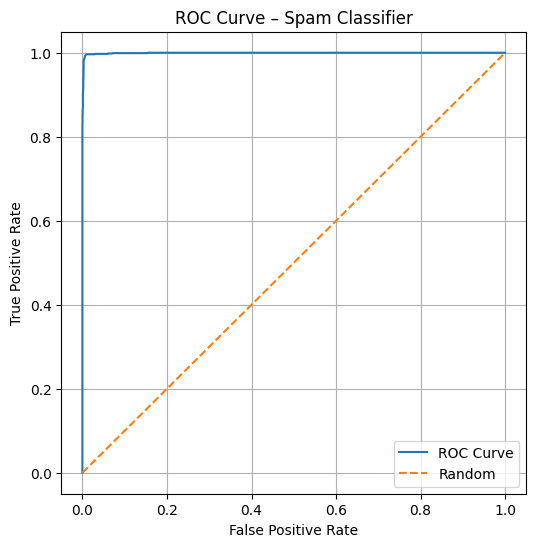

In [28]:
import matplotlib.pyplot as plt

roc_pd = roc_df.toPandas()

plt.figure(figsize=(6, 6))
plt.plot(roc_pd["FPR"], roc_pd["TPR"], label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Spam Classifier")
plt.legend()
plt.grid(True)
plt.show()


In [36]:
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

predictions = model.transform(testDF)

roc_input = predictions.select(
    col("label").cast("double"),
    vector_to_array("probability")[1].alias("score")  # P(spam)
)

In [37]:
roc_input.show(5)

+-----+--------------------+
|label|               score|
+-----+--------------------+
|  0.0| 0.09054375399861636|
|  0.0|6.826054225494982E-5|
|  0.0| 0.05928033647787412|
|  0.0| 0.02029234348865816|
|  0.0|0.001841025287734...|
+-----+--------------------+
only showing top 5 rows


In [38]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="score",
    metricName="areaUnderROC"
)

auc = evaluator.evaluate(roc_input)
print("Area Under ROC:", auc)


Area Under ROC: 0.9908495496680036


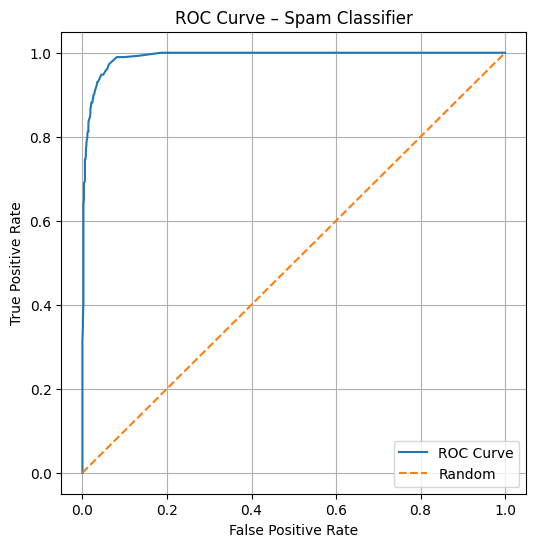

In [40]:
roc_pd = roc_input.toPandas()

import matplotlib.pyplot as plt
import numpy as np

thresholds = np.linspace(0, 1, 100)
tpr, fpr = [], []

for t in thresholds:
    preds = (roc_pd["score"] >= t).astype(int)

    tp = ((preds == 1) & (roc_pd["label"] == 1)).sum()
    fp = ((preds == 1) & (roc_pd["label"] == 0)).sum()
    fn = ((preds == 0) & (roc_pd["label"] == 1)).sum()
    tn = ((preds == 0) & (roc_pd["label"] == 0)).sum()

    tpr.append(tp / (tp + fn) if tp + fn > 0 else 0)
    fpr.append(fp / (fp + tn) if fp + tn > 0 else 0)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Spam Classifier")
plt.legend()
plt.grid(True)
plt.show()


In [39]:
#test_predictions = cvModel.transform(testDF)
#test_predictions.show(100)

In [ ]:
test_predictions.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
label|prediction|count|
+-----+----------+-----+
 1| 0.0| 37|
 0| 0.0| 883|
 1| 1.0| 238|
 0| 1.0| 6|
+-----+----------+-----+

In [ ]:
print(my_eval_lr.evaluate(test_predictions))

0.9293526945495449

In [ ]:
acc = (883 + 238)/ (883 + 37 + 238 + 6)
print(acc)

0.9630584192439863

In [ ]:
prec = (883)/(883 + 37)
print(prec)

0.9597826086956521

In [ ]:
# Naive Bayes
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes()
paramGrid_nb = ParamGridBuilder() \
    .addGrid(nb.smoothing, np.linspace(0.3, 10, 10)) \
    .build()
crossval_nb = CrossValidator(estimator=nb,
                          estimatorParamMaps=paramGrid_nb,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds= 10) 
cvModel_nb = crossval_nb.fit(trainDF)


MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [ ]:
predictions_nb = cvModel_nb.transform(testDF)
predictions_nb.groupBy('label','prediction').count().show()

+-----+----------+-----+
label|prediction|count|
+-----+----------+-----+
 1| 0.0| 2|
 0| 0.0| 876|
 1| 1.0| 273|
 0| 1.0| 13|
+-----+----------+-----+

In [ ]:
my_eval_nb = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
my_eval_nb.evaluate(predictions_nb)

Out[19]: 0.9890520503118928